## Aims of this notebook: 
- Plot the LOFAR and Parker Solar Probe dynamic spectra 
- Resample, shift, and combine the spectra together 
- Detect type-III radio bursts and extract their info 
- Mapping the active regions on the Sun corresponding to the radio bursts 
- Calculate the emission intensity profiles of those active regions (e.g. DEM analysis) 
- Interferometric imaging of the sources of radio bursts 
- Explore spatial and temporal correlations between the radio bursts and the observers and among the active phenomena themselves 

### Initialize necessary packages 

In [1]:
import os
os.environ['CDF_LIB'] = '/home/peijin/cdf/cdf38_0-dist/lib'
import sys
sys.path.insert(1, '../') # make sure to use the code in this repo
import math
import numpy as np
from random import randint
np.random.seed(7)
import glob
import json
import requests
import datetime
import pytz
from spacepy import pycdf
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import pandas as pd
import astropy.io.fits as fits
import scipy
import matplotlib.colors as colors
from matplotlib.dates import DateFormatter
myFmt_date = DateFormatter('%Y/%m/%d')
myFmt_time = DateFormatter('%H:%M')
import matplotlib.dates as mdates
#import pytz
#import matplotlib.dates as dates
# try to use the precise epoch 
import matplotlib as mpl
mpl.rcParams['date.epoch'] = '1970-01-01T00:00:00'
try:
    mdates.set_epoch('1970-01-01T00:00:00')
except:
    pass
import radioTools_ver2 as rt
import detectRadioburst_ver2 as drb
import astrospice
import astropy.units as u
import astropy.constants as const
from astropy.time import Time, TimeDelta
from sunpy.coordinates import HeliographicStonyhurst, get_body_heliographic_stonyhurst
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.facecolor'] = 'white'
#plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['savefig.facecolor'] = 'white'

/home/mnedal/.conda/envs/psp/lib/python3.9/site-packages/spacepy/time.py:2365: UserWarning: Leapseconds may be out of date. Use spacepy.toolbox.update(leapsecs=True)
  warnings.warn('Leapseconds may be out of date.'


### Define the date and the directories  

In [2]:
YEAR = '2019'
MONTH = '04'
DAY = '03'
SASID_LBA = 'L700169'
SASID_HBA = ''

psp_dir = '/home/mnedal/ASTRON/PSP/DATA/'
psp_hfr_dir = '/home/mnedal/ASTRON/PSP/DATA/hfr/'
psp_lfr_dir = '/home/mnedal/ASTRON/PSP/DATA/lfr/'
solo_dir = '/home/mnedal/ASTRON/SolO/DATA/'
lofar_dir = '/home/mnedal/ASTRON/LOFAR/DATA/'
wind_dir = '/home/mnedal/ASTRON/Wind/DATA/'
stereo_dir = '/home/mnedal/ASTRON/STEREO/DATA/'
basedir = '/HDD/mnedal'

--- 

## PSP data 

### LFR 

In [3]:
try:
    URL = 'http://research.ssl.berkeley.edu/data/psp/data/sci/fields/l2/rfs_lfr/'+YEAR+'/'+MONTH+'/psp_fld_l2_rfs_lfr_'+YEAR+MONTH+DAY+'_v02.cdf'
    response = requests.get(URL)
    open(os.path.join(psp_hfr_dir, '/psp_fld_l2_rfs_lfr_'+YEAR+MONTH+DAY+'_v02.cdf'), 'wb').write(response.content)
except:
     pass

cdf_psp_lfr = pycdf.CDF(os.path.join(psp_lfr_dir, 'psp_fld_l2_rfs_lfr_'+YEAR+MONTH+DAY+'_v02.cdf'))

tmin_lfr = cdf_psp_lfr['epoch_lfr'].meta['SCALEMIN']
tmax_lfr = cdf_psp_lfr['epoch_lfr'].meta['SCALEMAX']

# convert pixels values to dB, # z-axis 
arr_lfr = np.array(cdf_psp_lfr.get('psp_fld_l2_rfs_lfr_auto_averages_ch0_V1V2'))
# the min power scaled power spectral density (PSD) of 1e-16 is used as a threshold according to Pulupa et al. 2020, https://doi.org/10.3847/1538-4365/ab5dc0 
# more info: https://en.wikipedia.org/wiki/Decibel 
Lp_lfr = 10 * np.log10(arr_lfr/10**-16)
# x-axis 
tm_lfr = np.array(cdf_psp_lfr.get('epoch_lfr'))
# y-axis 
freq_lfr = np.array(cdf_psp_lfr.get('frequency_lfr_auto_averages_ch0_V1V2'))[1]/10**6

# clean the dyspec by subtracting the Mean val from each freq channel 
df_psp_lfr = pd.DataFrame(Lp_lfr.T)
df_psp_lfr_mean = df_psp_lfr.mean(axis=1)

# subtract that mean value from each corresponding row 
df_psp_lfr = df_psp_lfr.sub(df_psp_lfr_mean, axis=0)

### HFR 

In [4]:
try:
    URL = 'http://research.ssl.berkeley.edu/data/psp/data/sci/fields/l2/rfs_hfr/'+YEAR+'/'+ MONTH+'/psp_fld_l2_rfs_hfr_'+YEAR+MONTH+DAY+'_v02.cdf'
    response = requests.get(URL)
    open(os.path.join(psp_hfr_dir, '/psp_fld_l2_rfs_hfr_'+YEAR+MONTH+DAY+'_v02.cdf'), 'wb').write(response.content)
except:
     pass

cdf_psp_hfr = pycdf.CDF(os.path.join(psp_hfr_dir, 'psp_fld_l2_rfs_hfr_'+YEAR+MONTH+DAY+'_v02.cdf'))

tmin_hfr = cdf_psp_hfr['epoch_hfr'].meta['SCALEMIN']
tmax_hfr = cdf_psp_hfr['epoch_hfr'].meta['SCALEMAX']

# convert pixels values to dB, # z-axis 
arr_hfr = np.array(cdf_psp_hfr.get('psp_fld_l2_rfs_hfr_auto_averages_ch0_V1V2'))
Lp_hfr = 10 * np.log10(arr_hfr/10**-16)
# x-axis 
tm_hfr = np.array(cdf_psp_hfr.get('epoch_hfr'))
# y-axis 
freq_hfr = np.array(cdf_psp_hfr.get('frequency_hfr_auto_averages_ch0_V1V2'))[1]/10**6

# clean the dyspec by subtracting the Mean val from each freq channel 
df_psp_hfr = pd.DataFrame(Lp_hfr.T)
df_psp_hfr_mean = df_psp_hfr.mean(axis=1)

# subtract that mean value from each corresponding row 
df_psp_hfr = df_psp_hfr.sub(df_psp_hfr_mean, axis=0)

Plot, after cleaning

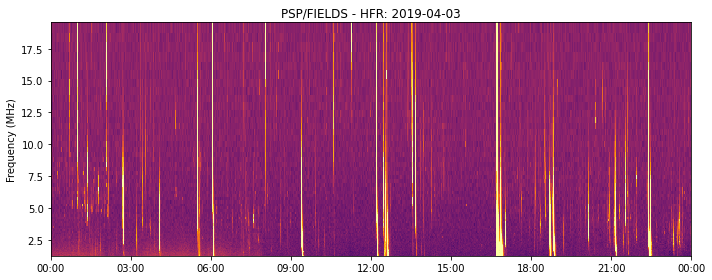

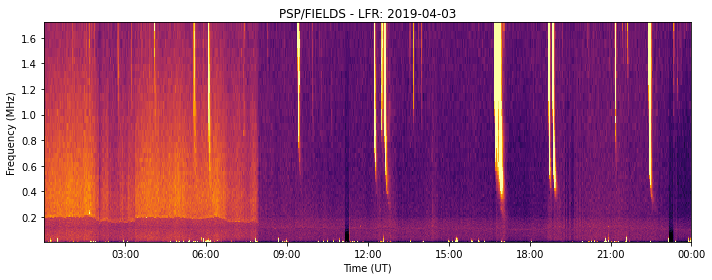

In [5]:
plt.figure(figsize=(10,4))
plt.pcolormesh(tm_hfr, freq_hfr, df_psp_hfr, 
               vmin=(np.mean(df_psp_hfr.values)-2 * np.std(df_psp_hfr.values)), 
               vmax=(np.mean(df_psp_hfr.values)+3 * np.std(df_psp_hfr.values)), 
               cmap='inferno') # viridis 
plt.ylabel('Frequency (MHz)')
plt.title('PSP/FIELDS - HFR: {}-{}-{}'.format(YEAR, MONTH, DAY))
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.pcolormesh(tm_lfr, freq_lfr, df_psp_lfr, 
               vmin=(np.mean(df_psp_lfr.values)-2 * np.std(df_psp_lfr.values)), 
               vmax=(np.mean(df_psp_lfr.values)+3 * np.std(df_psp_lfr.values)), 
               cmap='inferno') # viridis 
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title('PSP/FIELDS - LFR: {}-{}-{}'.format(YEAR, MONTH, DAY))
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
plt.show()

Concat. the 2 arrays of both bands and plot the combined spectrum

In [6]:
df_lfr = pd.DataFrame(df_psp_lfr)
df_lfr.insert(loc=0, column='frequency', value=freq_lfr)
df_lfr.set_index(['frequency'], inplace=True)

df_hfr = pd.DataFrame(df_psp_hfr)
df_hfr.insert(loc=0, column='frequency', value=freq_hfr)
df_hfr.set_index(['frequency'], inplace=True)
df_psp = pd.concat([df_lfr, df_hfr])
df_psp = df_psp.sort_index(axis=0)

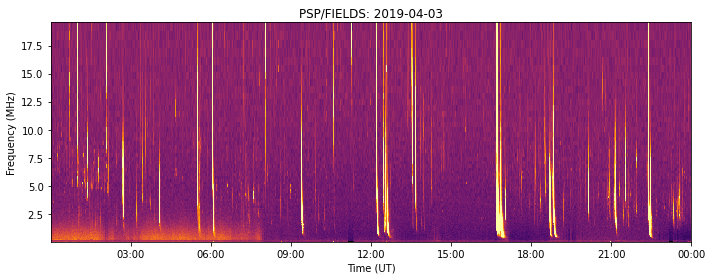

In [110]:
plt.figure(figsize=(10,4))
plt.pcolormesh(tm_lfr, df_psp.index.values, df_psp.values, 
               vmin=np.mean(df_psp.values)-2 * np.std(df_psp.values), 
               vmax=np.mean(df_psp.values)+3 * np.std(df_psp.values), 
               cmap='inferno')
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title('PSP/FIELDS: {}-{}-{}'.format(YEAR, MONTH, DAY))
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
#plt.savefig(psp_dir+'psp_full_spectrum_{}.png'.format(str(tm_hfr[0].replace(microsecond=0))[:10]))
plt.show()

Plot a normalized spectrum

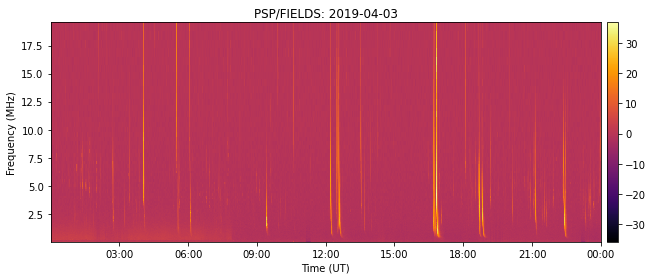

In [113]:
fig, ax = plt.subplots(1, 1, figsize=(10,4))
img = ax.pcolormesh(tm_lfr, df_psp.index.values, df_psp.values, 
                    norm=colors.CenteredNorm(vcenter=0.5), 
                    cmap='inferno')
fig.colorbar(img, ax=ax, pad=0.01)
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title('PSP/FIELDS: {}-{}-{}'.format(YEAR, MONTH, DAY))
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
plt.show()

Plot a specific time range of the spectrum

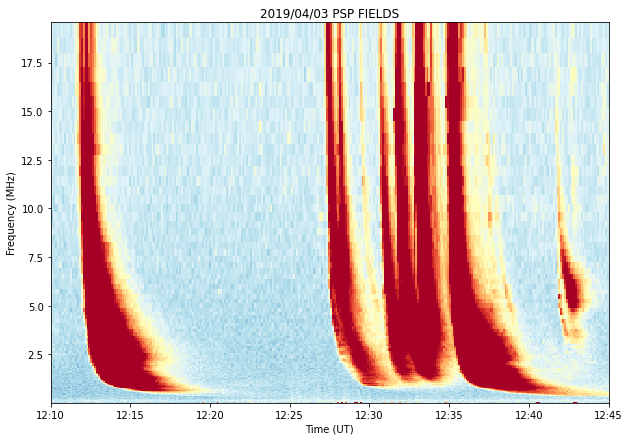

In [115]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
img = ax.pcolormesh(tm_lfr, df_psp.index.values, df_psp.values, 
                    vmin=np.mean(df_psp.values)-2 * np.std(df_psp.values), 
                    vmax=np.mean(df_psp.values)+3 * np.std(df_psp.values), 
                    cmap='RdYlBu_r') # ocean, inferno, jet, RdYlBu_r
#fig.colorbar(img, ax=ax, pad=0.01)
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_title(f'{YEAR}/{MONTH}/{DAY} PSP FIELDS')
ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt_time)
ax.set_xlim(left=pd.Timestamp('2019-04-03 12:10'), right=pd.Timestamp('2019-04-03 12:45'))
#plt.savefig(f'{basedir}/plots/psp_dyspec.png', dpi=300, format='png', bbox_inches='tight')
#plt.savefig(f'{basedir}/plots/psp_dyspec.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [116]:
print(f'PSP LFR frequency range:\t{freq_lfr[0]*1e3:.2f} kHz -- {freq_lfr[-1]:.2f} MHz')
print(f'PSP HFR frequency range:\t{freq_hfr[0]:.2f} MHz -- {freq_hfr[-1]:.2f} MHz')
print(f'PSP total frequency range:\t{df_psp.index.values[0]*1e3:.2f} kHz -- {df_psp.index.values[-1]:.2f} MHz')

PSP LFR frequency range:	10.55 kHz -- 1.69 MHz
PSP HFR frequency range:	1.27 MHz -- 19.17 MHz
PSP total frequency range:	10.55 kHz -- 19.17 MHz


--- 

## LOFAR 

### LBA 

In [9]:
# import fits files
lofar_LBA_fits = glob.glob(lofar_dir+'{}_{}{}{}_LBA'.format(SASID_LBA, YEAR, MONTH, DAY)+'/LOFAR_{}{}{}_*.fits'.format(YEAR, MONTH, DAY))
try:
    lofar_LBA_fits.remove(lofar_dir+'{}_{}{}{}_LBA'.format(SASID_LBA, YEAR, MONTH, DAY)+'/LOFAR_{}{}{}_LBA_OUTER.fits'.format(YEAR, MONTH, DAY))
except:
    pass
lofar_LBA_fits.sort()

# import json files
lofar_LBA_json = glob.glob(lofar_dir+'{}_{}{}{}_LBA'.format(SASID_LBA, YEAR, MONTH, DAY)+'/LOFAR_{}{}{}_*.json'.format(YEAR, MONTH, DAY))
try:
    lofar_LBA_json.remove(lofar_dir+'{}_{}{}{}_LBA'.format(SASID_LBA, YEAR, MONTH, DAY)+'/LOFAR_{}{}{}_LBA_OUTER.json'.format(YEAR, MONTH, DAY))
except:
    pass
lofar_LBA_json.sort()

# read and store json filex in a list
LBA_json = []
for file in lofar_LBA_json:
    f = open(file)
    LBA_json.append(json.load(f))
    f.close()

In [10]:
# read the FREQ axis from one of the fits files
LBA_freq = fits.open(lofar_LBA_fits[0])[1].data['FREQ']

LBA_list = []
for i in range(len(lofar_LBA_fits)):
    # read the fits file 
    tmp = fits.open(lofar_LBA_fits[i])
    df = pd.DataFrame(tmp[0].data)
    # insert the datetimes as index 
    df.insert(loc=0, column='DateTime', value=tmp[2].data['TIME'])
    df.set_index(['DateTime'], inplace=True)
    # store the spectra 
    LBA_list.append(df)

# Concat. the list of spectra based on the time index
df_concat_LBA = pd.concat(LBA_list, axis=0)

In [11]:
print(f'LOFAR LBA frequency range:\t{LBA_freq[0]:.2f} MHz -- {LBA_freq[-1]:.2f} MHz')

LOFAR LBA frequency range:	19.82 MHz -- 80.16 MHz


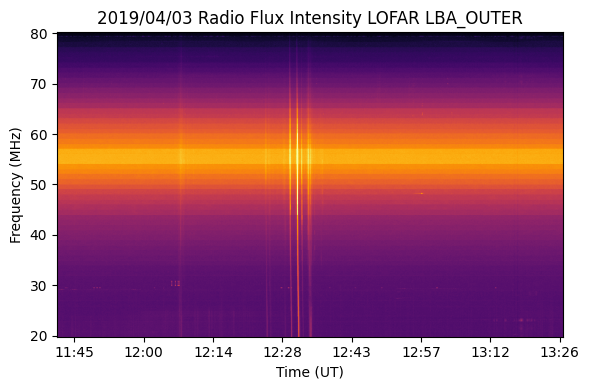

In [14]:
plt.figure(figsize=(6,4), dpi=100)
plt.imshow(df_concat_LBA.values.T, 
            aspect='auto', origin='lower', 
            vmin=(np.mean(df_concat_LBA.values)-2 * np.std(df_concat_LBA.values)), 
            vmax=(np.mean(df_concat_LBA.values)+3 * np.std(df_concat_LBA.values)), 
            extent=[df_concat_LBA.index.values[0], df_concat_LBA.index.values[-1], 
                    LBA_freq[0], LBA_freq[-1]], 
            cmap='inferno')
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title(fits.open(lofar_LBA_fits[0])[0].header['CONTENT'])
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
plt.show()

Const. background removal and gaussian smooth

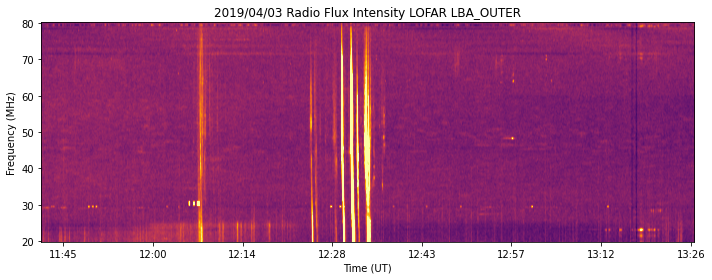

In [15]:
dyspec_lofar_lba = df_concat_LBA.copy()
(lofar_lba_new_tmp, lofar_lba_new) = drb.preproc(dyspec_lofar_lba, gauss_sigma=1.5)

plt.figure(figsize=[10,4])
plt.imshow(lofar_lba_new.T, 
            aspect='auto', origin='lower', 
            vmin=np.mean(lofar_lba_new)-2 * np.std(lofar_lba_new), 
            vmax=np.mean(lofar_lba_new)+3 * np.std(lofar_lba_new), 
            extent=[df_concat_LBA.index.values[0], df_concat_LBA.index.values[-1], 
                    LBA_freq[0], LBA_freq[-1]], 
            cmap='inferno') #RdBu 
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title(fits.open(lofar_LBA_fits[0])[0].header['CONTENT'])
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
plt.show()

--- 

### Define interesting period 

In [16]:
# set the start and end times of interest, assuming we are within the same day 
hh_st, MM_st = 12, 12
hh_et, MM_et = 12, 50

try:
    df_concat_LBA.index = mdates.num2date(df_concat_LBA.index)
except:
    pass

start_pivot = datetime.datetime(2019, 4, 3, hh_st, MM_st, tzinfo=df_concat_LBA.index[0].tz)
end_pivot = datetime.datetime(2019, 4, 3, hh_et, MM_et, tzinfo=df_concat_LBA.index[0].tz)

In [17]:
def nearest(items, pivot):
    '''
    This function returns the object in 'items' that is the closest to the object 'pivot'.
    '''
    found = min(items, key=lambda x: abs(x - pivot))
    return found

In [18]:
# get the nearest datetimes from LOFAR to the defined times above
st_lof_lba = nearest(df_concat_LBA.index, start_pivot)
et_lof_lba = nearest(df_concat_LBA.index, end_pivot)

# get their indices to be used for slicing the LOFAR data array
st_idx_lofar_lba = np.where(df_concat_LBA.index==st_lof_lba)[0][0]
et_idx_lofar_lba = np.where(df_concat_LBA.index==et_lof_lba)[0][0]

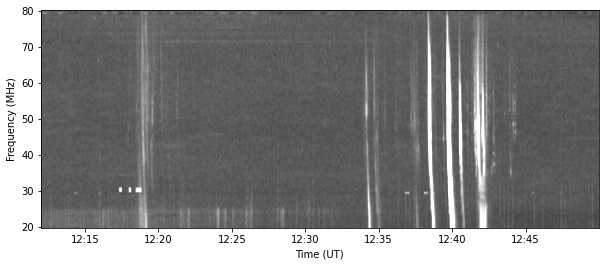

In [124]:
plt.figure(figsize=[10,4])
plt.imshow(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba].T, 
            aspect='auto', origin='lower', 
            vmin=(np.mean(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])-2 * np.std(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])), 
            vmax=(np.mean(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])+3 * np.std(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])), 
            extent=[mdates.date2num(df_concat_LBA.index[st_idx_lofar_lba:et_idx_lofar_lba][0]), 
                    mdates.date2num(df_concat_LBA.index[st_idx_lofar_lba:et_idx_lofar_lba][-1]), 
                    LBA_freq[0], LBA_freq[-1]], 
            cmap='gray') # inferno, RdYlBu_r, gray
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
#plt.title(fits.open(lofar_LBA_fits[0])[0].header['CONTENT'].replace('_', ' '))
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(myFmt_time)
#fig.savefig(f'{lofar_dir}lofar_LBA_spectrum_{str(tm_hfr[0].replace(microsecond=0))[:10]}.png', format='png', dpi=300, bbox_inches='tight')
#fig.savefig(f'{lofar_dir}lofar_LBA_spectrum_{str(tm_hfr[0].replace(microsecond=0))[:10]}.pdf', format='pdf', bbox_inches='tight')
plt.show()

Plot PSP within the same LOFAR's duration

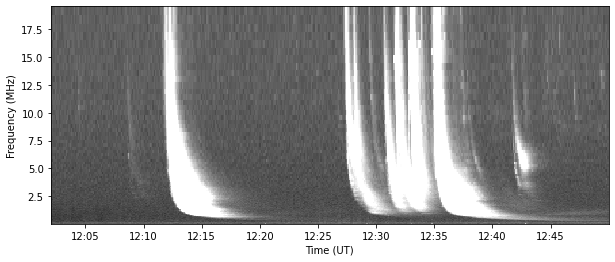

In [125]:
plt.figure(figsize=[10,4])
plt.pcolormesh(tm_lfr, df_psp.index.values, df_psp.values, 
                vmin=np.mean(df_psp.values)-2 * np.std(df_psp.values), 
                vmax=np.mean(df_psp.values)+3 * np.std(df_psp.values), 
                cmap='gray')
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
#plt.title(f'{YEAR}/{MONTH}/{DAY} PSP FIELDS')
plt.xlim(left=df_concat_LBA.index[st_idx_lofar_lba:et_idx_lofar_lba][0]-datetime.timedelta(minutes=10), 
         right=df_concat_LBA.index[st_idx_lofar_lba:et_idx_lofar_lba][-1])
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(myFmt_time)
#fig.savefig(f'{psp_dir}psp_full_spectrum_{str(tm_hfr[0].replace(microsecond=0))[:10]}.png', format='png', dpi=300, bbox_inches='tight')
#fig.savefig(f'{psp_dir}psp_full_spectrum_{str(tm_hfr[0].replace(microsecond=0))[:10]}.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [21]:
# set the same time zone as LOFAR for the PSP datetimes too
try:
    tm_lfr = [pytz.timezone('utc').localize(i) for i in tm_lfr]
except:
    pass

# get the nearest datetimes from PSP to the defined times above
st_psp = nearest(tm_lfr, start_pivot)
et_psp = nearest(tm_lfr, end_pivot)

# get their indices to be used for slicing the PSP data array
st_idx_psp = next((i for i, j in enumerate(tm_lfr) if j == st_psp), None)
et_idx_psp = next((i for i, j in enumerate(tm_lfr) if j == et_psp), None)

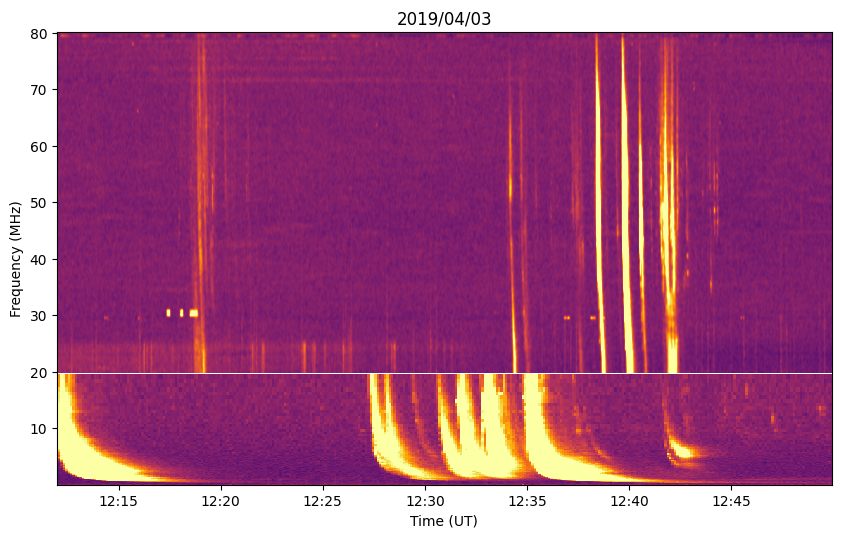

In [22]:
plt.figure(figsize=(10,6), dpi=100)

plt.imshow(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba].T, 
            aspect='auto', origin='lower', 
            vmin=(np.mean(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])-2 * np.std(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])), 
            vmax=(np.mean(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])+3 * np.std(lofar_lba_new[st_idx_lofar_lba:et_idx_lofar_lba])), 
            extent=[mdates.date2num(df_concat_LBA.index[st_idx_lofar_lba:et_idx_lofar_lba][0]), 
                    mdates.date2num(df_concat_LBA.index[st_idx_lofar_lba:et_idx_lofar_lba][-1]), 
                    LBA_freq[0], LBA_freq[-1]], 
            cmap='inferno')

plt.pcolormesh(tm_lfr, df_psp.index, df_psp.values, 
                vmin=(np.mean(df_psp.values)-2 * np.std(df_psp.values)), 
                vmax=(np.mean(df_psp.values)+3 * np.std(df_psp.values)), 
                cmap='inferno')

plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title('{}/{}/{}'.format(YEAR, MONTH, DAY))
plt.xlim(left=st_psp, right=et_psp)
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.show()

### Resampling 

In [23]:
# check cadence
lof_cadence = round((df_concat_LBA.index[1] - df_concat_LBA.index[0]).seconds + (df_concat_LBA.index[1] - df_concat_LBA.index[0]).microseconds/1e6)
psp_cadence = round((tm_lfr[1] - tm_lfr[0]).seconds + (tm_lfr[1] - tm_lfr[0]).microseconds/1e6)

# down-sample LOFAR w.r.t. PSP
df_lof_lba = pd.DataFrame(lofar_lba_new)
df_lof_lba.insert(loc=0, column='DateTime', value=df_concat_LBA.index)
df_lof_lba.set_index(['DateTime'], inplace=True)

resamp_lofar_lba = df_lof_lba.resample(str(psp_cadence)+'S').sum()

### Calculate the time travel for radio waves to PSP and LOFAR 

In [24]:
kernels = astrospice.registry.get_kernels('psp', 'recon')
psp_kernel = kernels[0]
coverage = psp_kernel.coverage('SOLAR PROBE PLUS')

Files Downloaded:   0%|          | 0/27 [00:00<?, ?file/s]

In [25]:
start_obstime = Time('{}-{}-{}T00:00:00'.format(YEAR, MONTH, DAY))
end_obstime = Time('{}-{}-{}T00:00:00'.format(YEAR, MONTH, DAY)) + TimeDelta(1*u.day)

dt = TimeDelta(1*u.day)
times = Time(np.arange(start_obstime, end_obstime, dt))
coords = astrospice.generate_coords('SOLAR PROBE PLUS', times)

new_frame = HeliographicStonyhurst()
coords = coords.transform_to(new_frame)

# get the Sun and Earth coordinates
obj_lst = ['Sun', 'Earth']
obj_coord = [get_body_heliographic_stonyhurst(obj, time=start_obstime) for obj in obj_lst]

# convert units to AU
psp_distAU = np.array(coords.radius.to(u.AU))[0]
earth_distAU = np.array(obj_coord[1].radius).reshape(-1)[0]

# convert units to m.
psp_dist = np.array(coords.radius.to(u.m))[0]
earth_dist = np.array(obj_coord[1].radius.to(u.m)).reshape(-1)[0]

# get the time (seconds) for electromagnetic waves to travel from the Sun to the target (PSP, Earth)
EM_t_travel_psp = psp_dist/np.array(const.c).reshape(-1)[0]
EM_t_travel_earth = earth_dist/np.array(const.c).reshape(-1)[0]

### Shifting PSP data to match LOFAR 

In [26]:
psp_struct = pd.DataFrame(df_psp.values.T)
psp_struct.insert(loc=0, column='DateTime', value=tm_lfr)
psp_struct.set_index(['DateTime'], inplace=True)

psp_shift = psp_struct.shift(periods=round((EM_t_travel_earth-EM_t_travel_psp)/psp_cadence), fill_value=0)

In [27]:
print(f'PSP frequency range: {df_psp.index.values[0]*1e3:.2f} kHz - {df_psp.index.values[-1]:.2f} MHz')
print(f'LOFAR LBA frequency range: {LBA_freq[0]:.2f} MHz - {LBA_freq[-1]:.2f} MHz')

PSP frequency range: 10.55 kHz - 19.17 MHz
LOFAR LBA frequency range: 19.82 MHz - 80.16 MHz


Plot after resampling and shifting

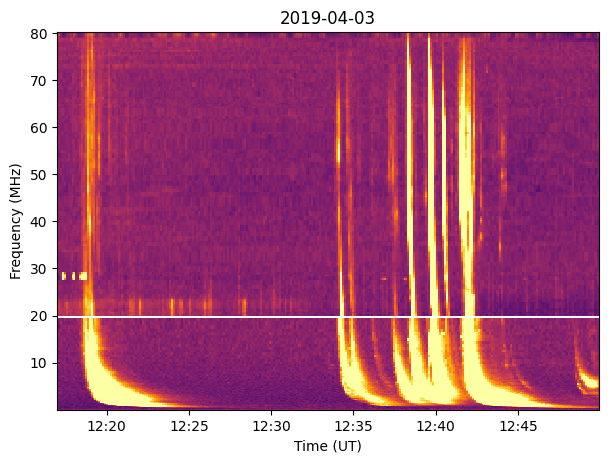

In [28]:
plt.figure(figsize=(7,5), dpi=100)

plt.pcolormesh(resamp_lofar_lba.index, LBA_freq, resamp_lofar_lba.T, 
                vmin=(np.mean(resamp_lofar_lba.values)-2 * np.std(resamp_lofar_lba.values)), 
                vmax=(np.mean(resamp_lofar_lba.values)+3 * np.std(resamp_lofar_lba.values)), 
                cmap='inferno')

plt.pcolormesh(psp_shift.index, df_psp.index.values, psp_shift.values.T, 
                vmin=(np.mean(psp_shift.values)-2 * np.std(psp_shift.values)), 
                vmax=(np.mean(psp_shift.values)+3 * np.std(psp_shift.values)), 
                cmap='inferno')

plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title('{}-{}-{}'.format(YEAR, MONTH, DAY))
plt.xlim(left=st_psp+datetime.timedelta(minutes=5), right=et_psp)
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.show()

### Combine the LOFAR and PSP spectra in a single array

In [29]:
sub1_tm_lof = nearest(resamp_lofar_lba.index, start_pivot)
sub2_tm_lof = nearest(resamp_lofar_lba.index, end_pivot)

subset1_lof = resamp_lofar_lba.index.get_loc(sub1_tm_lof)
subset2_lof = resamp_lofar_lba.index.get_loc(sub2_tm_lof)

### === LOFAR LBA =======

# define dataframe
df_LOFAR_LBA = pd.DataFrame(resamp_lofar_lba.values[subset1_lof:subset2_lof])
# define time 
df_LOFAR_LBA.insert(loc=0, column='DateTime', value=resamp_lofar_lba.index[subset1_lof:subset2_lof])
df_LOFAR_LBA.set_index(['DateTime'], inplace=True)
# define freq 
df_LOFAR_LBA.columns = LBA_freq

### === PSP HFR + LFR =======

# define dataframe 
df_PSP = pd.DataFrame(psp_shift[st_idx_psp:et_idx_psp].values)
# define time 
df_PSP.insert(loc=0, column='DateTime', value=psp_shift[st_idx_psp:et_idx_psp].index)
df_PSP.set_index(['DateTime'], inplace=True)
# define freq 
df_PSP.columns = df_psp.index.values

total_freq = np.concatenate([df_PSP.columns, df_LOFAR_LBA.columns])

# normalize PSP to LOFAR to match intensities 
normalize = False

if normalize:
    # get the nearest FREQ to 20 MHz
    norm_lof_freq = nearest(LBA_freq, 20)
    norm_psp_freq = nearest(df_psp.index.values, 20)

    norm_freq_idx_lof = np.where(LBA_freq==norm_lof_freq)[0][0]
    norm_freq_idx_psp = np.where(df_PSP.columns.values==norm_psp_freq)[0][0]

    lof_norm = (df_PSP.values[:, norm_freq_idx_psp]/df_LOFAR_LBA.values[:, norm_freq_idx_lof])*df_LOFAR_LBA.values.T
    psp_norm = (df_PSP.values[:, norm_freq_idx_psp]/df_LOFAR_LBA.values[:, norm_freq_idx_lof])*df_PSP.values.T
    
    # combine both spectra
    finool = np.concatenate([psp_norm, lof_norm], axis=0).T

else:
    # combine both spectra
    finool = np.concatenate([df_PSP.values, df_LOFAR_LBA.values], axis=1)

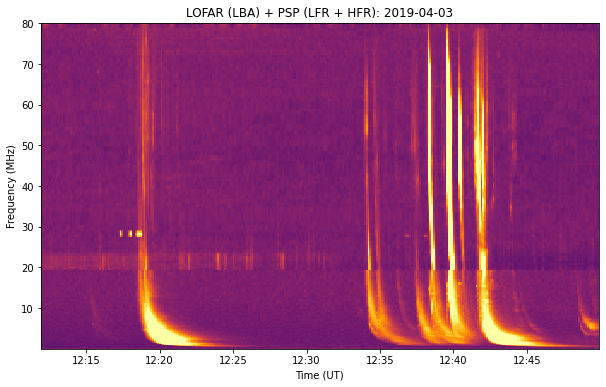

In [128]:
plt.figure(figsize=[10,6])
plt.pcolormesh(df_PSP.index, total_freq, finool.T, 
                vmin=(np.mean(finool)-2 * np.std(finool)), 
                vmax=(np.mean(finool)+3 * np.std(finool)), 
                cmap='inferno')
#plt.colorbar(pad=0.01)
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title('LOFAR (LBA) + PSP (LFR + HFR): {}-{}-{}'.format(YEAR, MONTH, DAY))
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.show()

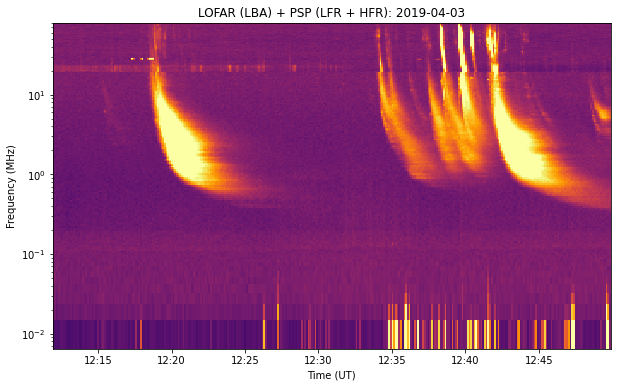

In [126]:
plt.figure(figsize=[10,6])
plt.pcolormesh(df_PSP.index, total_freq, finool.T, 
                vmin=(np.mean(finool)-2 * np.std(finool)), 
                vmax=(np.mean(finool)+3 * np.std(finool)), 
                cmap='inferno')
#plt.colorbar(pad=0.01)
plt.yscale('log')
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.title('LOFAR (LBA) + PSP (LFR + HFR): {}-{}-{}'.format(YEAR, MONTH, DAY))
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.show()

Take only the frequencies above 0.1 MHz (100 kHz)

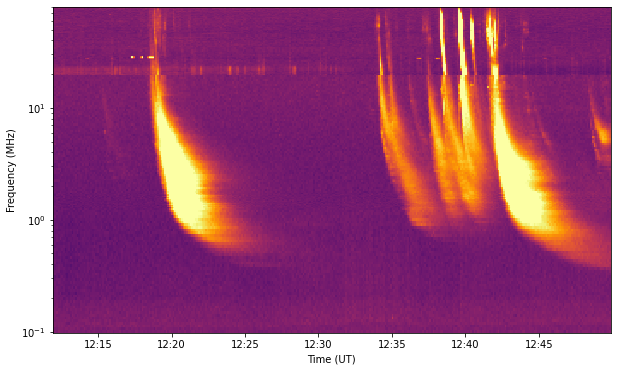

In [127]:
plt.figure(figsize=[10,6])
plt.pcolormesh(df_PSP.index, 
               total_freq[total_freq>0.1], 
               finool[:,-total_freq[total_freq>0.1].shape[0]:].T, 
               vmin=(np.mean(finool[:,-total_freq[total_freq>0.1].shape[0]:])-2 * np.std(finool[:,-total_freq[total_freq>0.1].shape[0]:])), 
               vmax=(np.mean(finool[:,-total_freq[total_freq>0.1].shape[0]:])+3 * np.std(finool[:,-total_freq[total_freq>0.1].shape[0]:])), 
               cmap='inferno')
#plt.colorbar(pad=0.01)
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.yscale('log')
#plt.title(f'{YEAR}/{MONTH}/{DAY} LOFAR (LBA) with PSP (LFR + HFR)')
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(myFmt_time)
#fig.savefig('/home/mnedal/ASTRON/combined_dyspec_colored.png', format='png', dpi=300, bbox_inches='tight')
#fig.savefig('/home/mnedal/ASTRON/combined_dyspec_colored.pdf', format='pdf', bbox_inches='tight')
plt.show()

In [33]:
print(f'Total frequency range for the combined spectrum above: {total_freq[total_freq>0.1][0]:.2f} -- {total_freq[total_freq>0.1][-1]:.2f} MHz')

Total frequency range for the combined spectrum above: 0.10 -- 80.16 MHz


--- 

## Detect Type-III radio bursts 

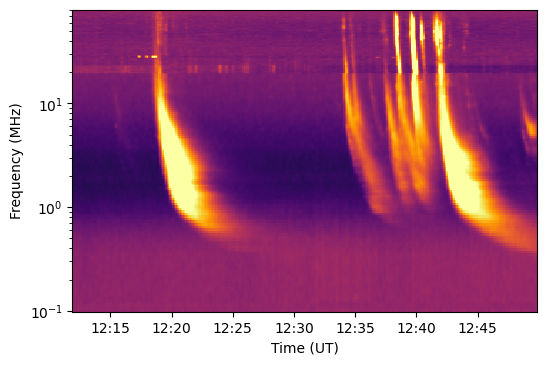

In [36]:
# select the FREQ above 0.1 MHz 
typeIII_finool = finool[:,-total_freq[total_freq>0.1].shape[0]:]
typeIII_freq = total_freq[total_freq>0.1]
t_fits = np.array([mdates.date2num(i) for i in df_PSP.index])

# const background removal and gaussian smooth 
(data_fits_new_tmp, data_fits_new) = drb.preproc(typeIII_finool, gauss_sigma=0.7)

plt.figure(figsize=(6,4), dpi=100)
plt.pcolormesh(df_PSP.index, typeIII_freq, data_fits_new.T, 
                vmin=(np.mean(data_fits_new)-2 * np.std(data_fits_new)),
                vmax=(np.mean(data_fits_new)+3 * np.std(data_fits_new)),
                cmap='inferno')
plt.yscale('log')
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.gca().xaxis_date()
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.show()

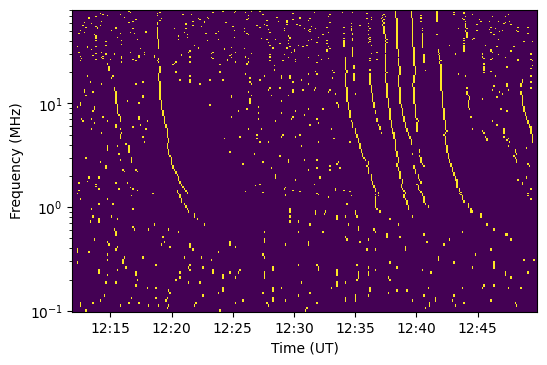

In [37]:
# binarization
local_max = False
#N_order = 4
#peak_r = 0.998

#canny_filter = False
#canny_sigma = 1.3
#canny_thresholds = [0.4, 20]

if local_max:
    bmap = drb.binarization(data_fits_new, N_order=4, peak_r=0.997)

#elif canny_filter:
#    from skimage.feature import canny
#    bmap = canny(data_fits_new, sigma=canny_sigma, low_threshold=canny_thresholds[0], high_threshold=canny_thresholds[1])

bmap = drb.binarization(data_fits_new, N_order=4, peak_r=0.9995)

plt.figure(figsize=[6,4], dpi=100)
plt.pcolormesh(df_PSP.index, typeIII_freq, bmap.T)
plt.yscale('log')
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.show()

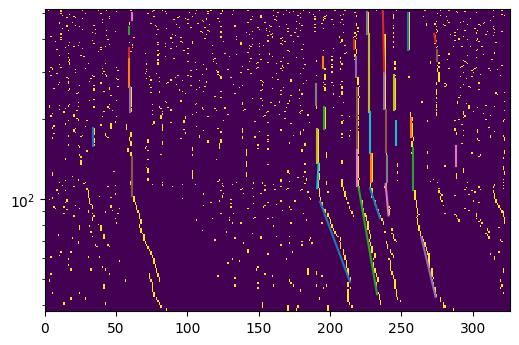

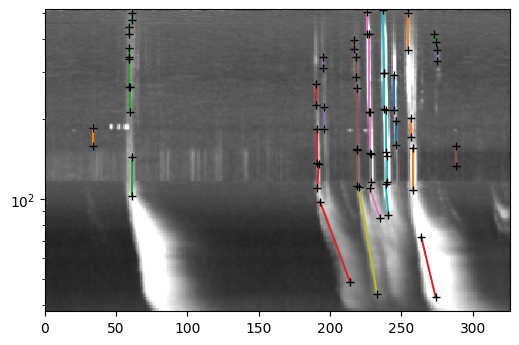

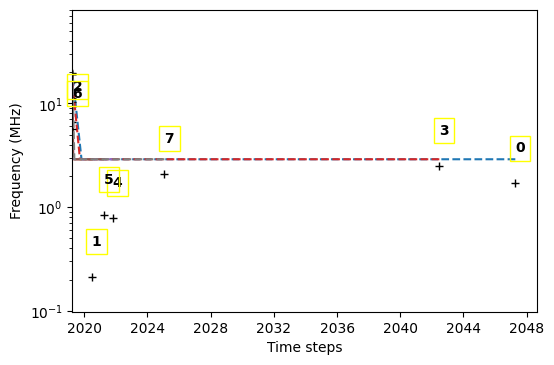

In [76]:
# detect verticle features, apply the probabilistic Hough transformation 
### with Parker fit model
#lines = drb.hough_detect(bmap, dyspec_lofar_lba, threshold=35, line_gap=11, line_length=25, 
#                         theta=np.linspace(np.radians(32), np.radians(270), 500))

### with Newkirk fit model
lines = drb.hough_detect(bmap, dyspec_lofar_lba, threshold=35, line_gap=5, line_length=25, 
                         theta=np.linspace(np.radians(32), np.radians(270), 500))

lines = sorted(lines, key=lambda i: i[0][1])
line_sets = drb.line_grouping(lines)

fig, ax = plt.subplots(1, 1, figsize=[6,4], dpi=100)
ax.pcolormesh(bmap.T)

for line in lines:
    p0, p1 = line
    ax.plot((p0[1],p1[1]), (p0[0],p1[0]))

ax.set_yscale('log')
plt.show()
# ======================================================== 

# group the detected lines into group in regard of events 
fig, ax = plt.subplots(1, 1, figsize=[6,4], dpi=100)
'''
ax.pcolormesh(data_fits_new.T, 
          vmin=(np.mean(data_fits_new)-2 * np.std(data_fits_new)), 
          vmax=(np.mean(data_fits_new)+2 * np.std(data_fits_new)), 
          cmap='gray')
'''
ax.pcolormesh(data_fits_new.T, 
                vmin=(np.mean(data_fits_new)-2 * np.std(data_fits_new)),
                vmax=(np.mean(data_fits_new)+3 * np.std(data_fits_new)),
                cmap='gray')

for idx, lines in enumerate(line_sets):
    for line in lines:
        p0, p1 = line
        ax.plot((p0[1],p1[1]), (p0[0],p1[0]), color='C'+str(idx+1))
        ax.plot((p0[1],p1[1]), (p0[0],p1[0]), 'k+', zorder=10)

ax.set_yscale('log')
plt.show()
# ========================================================

assumption = 'harmonic'

# fit the line segments
if assumption=='fundamental':
    (v_beam, 
     f_range_burst, t_range_burst, 
     model_curve_set, t_set_arr_set, 
     f_set_arr_set, t_model_arr, f_model_arr) = drb.get_info_from_linegroup(line_sets, t_fits, total_freq)

elif assumption=='harmonic':
    (v_beam, 
     f_range_burst, t_range_burst, 
     model_curve_set, t_set_arr_set, 
     f_set_arr_set, t_model_arr, f_model_arr) = drb.get_info_from_linegroup(line_sets, t_fits, np.array([f/2 for f in total_freq]))


fig, ax = plt.subplots(1, 1, figsize=[6,4], dpi=100)

ax.pcolormesh(df_PSP.index, typeIII_freq, data_fits_new.T, 
                vmin=(np.mean(data_fits_new)-2 * np.std(data_fits_new)),
                vmax=(np.mean(data_fits_new)+3 * np.std(data_fits_new)),
                cmap='gray')

for idx, model in enumerate(model_curve_set):
    ax.plot(model[0], model[1], ls='--')
    if assumption=='fundamental':
        ax.plot(t_range_burst[idx], f_range_burst[idx], 'k+')
    elif assumption=='harmonic':
        ax.plot(t_range_burst[idx], [f/2 for f in f_range_burst[idx]], 'k+')
    ax.text(t_range_burst[idx][0], f_range_burst[idx][0], 
            str(idx), color='black', weight='bold', bbox=dict(facecolor='none', edgecolor='yellow'))

#ax.xaxis_date()
#ax.xaxis.set_major_formatter(myFmt_time)
#ax.set_xlabel('Time (UT)')
ax.set_xlabel('Time steps')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
#ax.set_xlim(mdates.date2num(df_PSP.index[0]), mdates.date2num(df_PSP.index[20]))
#plt.savefig('/home/mnedal/ASTRON/auto_detect_typeIIIs.png', format='png', dpi=300, facecolor='white')
#plt.savefig('/home/mnedal/ASTRON/auto_detect_typeIIIs.pdf', format='pdf', facecolor='white')
plt.show()

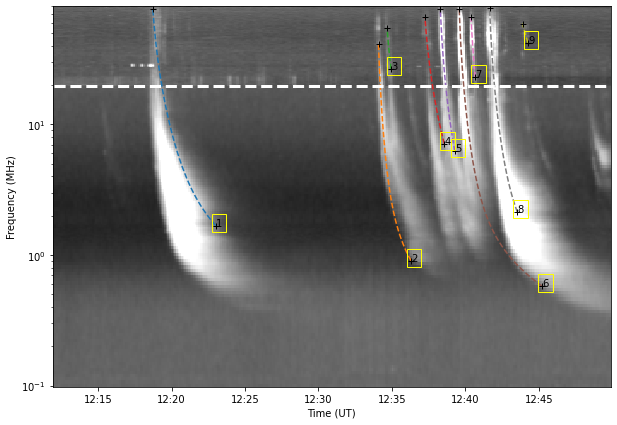

In [43]:
fig, ax = plt.subplots(1, 1, figsize=[10,7])
ax.pcolormesh(df_PSP.index, typeIII_freq, data_fits_new.T, 
                vmin=(np.mean(data_fits_new)-2 * np.std(data_fits_new)),
                vmax=(np.mean(data_fits_new)+3 * np.std(data_fits_new)),
                cmap='gray')

for idx, model in enumerate(model_curve_set):
    ax.plot(model[0], model[1], ls='--')
    ax.plot(t_range_burst[idx], f_range_burst[idx], 'k+')
    ax.text(t_range_burst[idx][0], f_range_burst[idx][0], 
            str(idx+1), color='black', 
            #weight='bold', 
            bbox=dict(facecolor='none', edgecolor='yellow'))

ax.hlines(y=(df_psp.index.values[-1] + LBA_freq[0])/2, 
          xmin=df_PSP.index[0], xmax=df_PSP.index[-1],
          colors='white', linestyles='dashed', lw=3)

ax.xaxis_date()
ax.xaxis.set_major_formatter(myFmt_time)
ax.set_xlabel('Time (UT)')
ax.set_ylabel('Frequency (MHz)')
ax.set_yscale('log')
#plt.savefig('/home/mnedal/ASTRON/auto_detect_typeIIIs.pdf', format='pdf', bbox_inches='tight')
#plt.savefig('/home/mnedal/ASTRON/auto_detect_typeIIIs.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

--- 

## Export the bursts info 

In [ ]:
with open(lofar_LBA_json[0], 'r') as fp:
    dict_old = json.load(fp)
fp.close()

In [ ]:
event_detail = []
for idx, v_cur in enumerate(v_beam):
    event_detail.append({
        'v_beam': float(f'{v_cur:.3f}'), 
        'freq_range': (float(f'{f_range_burst[idx][0]:.2f}'), float(f'{f_range_burst[idx][1]:.2f}')), 
        'time_range': (mdates.num2date(t_range_burst[idx][0]).strftime('%H:%M:%S'), 
                       mdates.num2date(t_range_burst[idx][1]).strftime('%H:%M:%S')),
        'str_time': mdates.num2date(t_range_burst[idx][0]).strftime('%H:%M:%S')})

In [ ]:
dict_old['event'] = {'detection': True, 
                     'type':'III', 
                     'detail': event_detail}

In [ ]:
# dump information to json file 
with open('/home/mnedal/ASTRON/json/event_detail_{}{}{}.json'.format(YEAR, MONTH, DAY), 'w') as fp:
     json.dump(dict_old, fp)
fp.close()

In [74]:
#DATE = []
ST_TIME = []
ET_TIME = []
ST_FREQ = []
ET_FREQ = []
df_dt = []
V_BEAM = []

for idx, v_cur in enumerate(v_beam):
    #DATE.append(mdates.num2date(t_range_burst[idx][0]).strftime('%Y-%m-%d'))
    ST_TIME.append(mdates.num2date(t_range_burst[idx][1]).strftime('%H:%M:%S'))
    ET_TIME.append(mdates.num2date(t_range_burst[idx][0]).strftime('%H:%M:%S'))
    ST_FREQ.append(float(f'{f_range_burst[idx][1]:.2f}'))
    ET_FREQ.append(float(f'{f_range_burst[idx][0]:.2f}'))

    df = np.max(f_set_arr_set[idx])-np.min(f_set_arr_set[idx])
    dt = np.max(t_set_arr_set[idx])-np.min(t_set_arr_set[idx])
    df_dt.append(float(f'{df/dt:.3f}'))
    V_BEAM.append(float(f'{v_beam[idx]:.3f}'))

df_events = pd.DataFrame({
    'event_ID': np.arange(len(v_beam)),
    #'date': DATE, 
    'st_time': ST_TIME, 
    'et_time': ET_TIME, 
    'st_freq(mhz)': ST_FREQ, 
    'et_freq(mhz)': ET_FREQ, 
    'df_dt(mhz_s)': df_dt, 
    'v_beam(C)': V_BEAM
})

df_events.set_index(['event_ID'], inplace=True)
df_events.to_csv(f'/home/mnedal/ASTRON/csv/event_detail_{YEAR}{MONTH}{DAY}.csv')
df_events

st_time   et_time  st_freq(mhz)  et_freq(mhz)  df_dt(mhz_s)  \
event_ID                                                                 
0         12:19:00  13:32:38         38.22          0.84         0.535   
1         12:34:16  12:34:56         20.62         10.14         1.499   
2         12:34:50  12:35:16         27.22         13.27         1.996   
3         12:37:28  21:00:57         31.99          5.01         1.930   
4         12:38:26  04:17:17         38.49          1.44         0.530   
5         12:39:44  16:30:27         38.03          1.69         1.300   
6         12:40:40  12:41:16         22.67         11.45         1.605   
7         12:41:46  00:40:59         38.44          4.21         1.632   
8         12:44:59  12:45:38         33.01         26.25         0.484   

          v_beam(C)  
event_ID             
0             0.106  
1             0.284  
2             0.248  
3             0.145  
4             0.189  
5             0.179  
6             0.235  
7             0.241  
8             0.026

--- 

### Plot the frequency drift and the speed of the electron beam with time and distance 

In [ ]:
def calc_total_seconds(datetimeobj):
    tot_s = int(datetimeobj.strftime('%S'))
    tot_s += int(datetimeobj.strftime('%M')) * 60
    tot_s += int(datetimeobj.strftime('%H')) * 60 * 60
    tot_s += (int(datetimeobj.strftime('%j')) - 1) * 60 * 60 * 24
    tot_s += (int(datetimeobj.strftime('%Y')) - 1970) * 60 * 60 * 24 * 365
    return tot_s

In [ ]:
print('Number of detected type-IIIs: {}'.format(len(model_curve_set)))

In [ ]:
# plot f vs t for all type-IIIs together 
tm_fit_all, freq_fit_all = [], []

plt.figure(figsize=(8,6))
# except the last burst 
for idx, burst in enumerate(model_curve_set[:-1]):
    # get time steps 
    tm_fit = burst[0].reshape(-1)
    tm_fit_all.append(tm_fit)
    # get frequencies 
    freq_fit = burst[1].reshape(-1)
    freq_fit_all.append(freq_fit)
    # plot 
    plt.plot(tm_fit, freq_fit, label='Burst {}'.format(idx+1))

plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.legend(frameon=False)
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.yscale('log')
plt.tight_layout()
#plt.savefig('/home/mnedal/ASTRON/f_vs_t.png', format='png', dpi=300, facecolor='white')
plt.show()

In [ ]:
### calc the freq drift per event 
# calc the time diff in sec. 
tm_fit_all_datetime = [mdates.num2date(t[::-1]) for t in tm_fit_all]
diff_tm_list = []
for dt in tm_fit_all_datetime:
    diff_tm_list.append(np.diff(dt))
diff_tm_s_all = []
for dt in diff_tm_list:
    diff_tm_s_all.append([t.seconds + (t.microseconds/1e6) for t in dt])

# calc the freq diff in MHz 
diff_freq_list = []
for df in freq_fit_all:
    diff_freq_list.append(np.diff(df[::-1]))

# plot df/dt vs time for all type-IIIs together 
plt.figure(figsize=(7,5))
# except the last burst 
for idx, burst in enumerate(model_curve_set[:-1]):
    # get time steps 
    tm_fit = burst[0].reshape(-1)[::-1]
    # plot df/dt 
    dfdt = diff_freq_list[idx]/diff_tm_s_all[idx]
    plt.plot(tm_fit[1:], dfdt, label='Burst #%i' %idx)

plt.xlabel('Time (UT)')
plt.ylabel('df/dt (MHz/s)')
plt.legend(loc='upper left')
plt.gca().invert_yaxis()
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
#plt.savefig('/home/mnedal/ASTRON/dfdt_vs_t.png', format='png', dpi=300, facecolor='white')
plt.show()

In [ ]:
# take the first burst, and reverse it so that the output height looks realistic (e.g. away from the Sun) 
f_pe = model_curve_set[0][1].reshape(-1)[::-1]*1e6
r_parker = []
r_saito = []
r_newkirk = []
r_leblanc = []
for i in range(len(f_pe)):
    r_parker.append(rt.freq_to_R(f_pe[i], ne_r=rt.parkerfit))
    r_saito.append(rt.freq_to_R(f_pe[i], ne_r=rt.saito77))
    r_newkirk.append(rt.freq_to_R(f_pe[i], ne_r=rt.newkirk))
    r_leblanc.append(rt.freq_to_R(f_pe[i], ne_r=rt.dndr_leblanc98))

In [ ]:
# plot df/dt vs height for all type-IIIs together 
plt.figure(figsize=(7,5))
# except the last burst 
for idx, burst in enumerate(model_curve_set[:-1]):
    # get time steps 
    tm_fit = burst[0].reshape(-1)[::-1]
    # get frequencies and convert it to Hz 
    freq_fit = burst[1].reshape(-1)[::-1]
    # convert freq to height 
    r_parker = []
    for i in range(len(freq_fit)):
        # convert f from MHz to Hz for the model solver to work properly 
        r_parker.append(rt.freq_to_R(freq_fit[i]*1e6, ne_r=rt.parkerfit))
    # plot df/dt 
    dfdt = diff_freq_list[idx]/diff_tm_s_all[idx]
    plt.plot(r_parker[1:], dfdt, label='Burst #%i v = %.2f c' %(idx, v_beam[idx]))

plt.xlabel('Height ($R_S$)')
plt.ylabel('df/dt (MHz/s)')
plt.legend(loc='upper right')
plt.gca().invert_yaxis()
plt.tight_layout()
#plt.savefig('/home/mnedal/ASTRON/dfdt_vs_h-parkerfit.png', format='png', dpi=300, facecolor='white')
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(f_pe/1e6, r_parker, label='parker')
plt.plot(f_pe/1e6, r_saito, label='saito')
plt.ylabel('Height (unit ??)')
plt.xlabel('Frequency (MHz)')
plt.legend()
plt.show()

In [ ]:
# plot freq vs height for all type-IIIs together 
plt.figure(figsize=(8,6))
# except the last burst 
for idx, burst in enumerate(model_curve_set[:-1]):
    # get frequencies and convert it to Hz 
    freq_fit = burst[1].reshape(-1)[::-1]*1e6
    # convert freq to height 
    r_parker = []
    r_saito = []
    for i in range(len(freq_fit)):
        r_parker.append(rt.freq_to_R(freq_fit[i], ne_r=rt.parkerfit))
    # plot 
    plt.plot(r_parker, freq_fit/1e6, label='Burst {}'.format(idx+1))

plt.xlabel('Height ($R_S$)')
plt.ylabel('df/dt (MHz/s)')
plt.legend(frameon=False)
plt.tight_layout()
#plt.savefig('/home/mnedal/ASTRON/f_vs_h-parkerfit.png', format='png', dpi=300, facecolor='white')
plt.show()

### Check individual bursts 

In [ ]:
# take the first type-III burst 
idx_event = 0
# get the time points and flip it with [::-1] to be realistic (e.g increases forward) 
tm_fit = model_curve_set[idx_event][0].reshape(-1)[::-1]
tm_fit_d = [mdates.num2date(d) for d in tm_fit]
#tm_fit_s = [calc_total_seconds(d) for d in tm_fit_d]
# get the frequency points and flip it with [::-1] to be realistic (e.g decreases forward) 
freq_fit = model_curve_set[idx_event][1].reshape(-1)[::-1]

In [ ]:
plt.plot(tm_fit, freq_fit)
plt.ylabel('Frequency (MHz)')
plt.xlabel('Time (UT)')
plt.yscale('log')
plt.gca().xaxis.set_major_formatter(myFmt_time)

In [ ]:
plt.plot(tm_fit[1:], np.diff(freq_fit)/np.diff(tm_fit))
plt.ylabel('df/dt (MHz/s)')
plt.xlabel('Time (UT)')
plt.gca().xaxis.set_major_formatter(myFmt_time)

In [ ]:
plt.plot(freq_fit[1:], np.diff(freq_fit)/np.diff(tm_fit))
plt.ylabel('df/dt (MHz/s)')
plt.xlabel('Frequency (MHz)')
plt.xscale('log')

In [ ]:
plt.plot(freq_fit, label='f')
plt.plot(np.diff(freq_fit), label='df')
plt.ylabel('Frequency (MHz)')
plt.legend()
#plt.xscale('log')

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(tm_fit, freq_fit)
plt.xlabel('Time (UT)')
plt.ylabel('Frequency (MHz)')
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(tm_fit[1:], np.diff(freq_fit)/np.diff(tm_fit))
plt.xlabel('Time (UT)')
plt.ylabel('df/dt (MHz/s)')
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.tight_layout()
plt.show()

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(tm_fit, rt.Ne_f(freq_fit*1e6))
plt.xlabel('Time (UT)')
plt.ylabel('Electron density (cm$^{-3}$)')
plt.gca().xaxis.set_major_formatter(myFmt_time)
plt.yscale('log')
plt.tight_layout()
plt.show()

In [ ]:
def omega_pe_r(ne_r, r):
    # plasma frequency density relationship
    return 8.93e3*(ne_r(r))**(0.5) * 2 * np.pi

def saito77(r):
    return 1.36e6 * r**(-2.14) + 1.68e8 * r**(-6.13)

def freq_to_R(f_pe, ne_r=parkerfit):
    """
    Starting height for wave frequency f
    """
    func = lambda R: f_pe - (omega_pe_r(ne_r, R)) /2/np.pi
    R_solution = fsolver(func, x0=1.5) # solve the R
    return R_solution # [R_s]


freq_to_R(freq_fit[0]*1e6, ne_r=saito77)

In [ ]:
r_parker = []
r_saito = []
r_newkirk = []
r_leblanc = []
for f in freq_fit:
    r_parker.append(rt.freq_to_R(f*1e6, ne_r=rt.parkerfit))
    r_saito.append(rt.freq_to_R(f*1e6, ne_r=rt.saito77))
    r_newkirk.append(rt.freq_to_R(f*1e6, ne_r=rt.newkirk))
    r_leblanc.append(rt.freq_to_R(f*1e6, ne_r=rt.dndr_leblanc98))

In [ ]:
plt.figure(figsize=(8,6))
#plt.plot(tm_fit, r_newkirk, label='Newkirk fit')
#plt.plot(tm_fit, r_leblanc, label='Leblanc fit')
plt.plot(tm_fit, r_saito, label='Saito fit')
plt.plot(tm_fit, r_parker, label='Parker fit')
plt.xlabel('Time (UT)')
plt.ylabel('Height ($R_S$)')
plt.legend(loc='best', frameon=False)
plt.gca().xaxis.set_major_formatter(myFmt_time)
#plt.yscale('log')
plt.tight_layout()
plt.show()